# HW04: RDD and Diff-in-Diff (due 26th October)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation.


## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).


In [ ]:
!pip install rdrobust


In [1]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None


In [2]:
df = pd.read_stata('data/HW04_data_rdd.dta')


/Users/federico/Library/Python/3.9/lib/python/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta',
                          iterator=True).variable_labels()
df_labels


/Users/federico/Library/Python/3.9/lib/python/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'uf': 'state',
 'nsorteio': 'Número do sorteio',
 'totrecursos': 'Total de recurso fiscalizado no municipio',
 'tot_os': 'Total de OS fiscalizadas no municipio',
 'pop': 'População no ano de 2000',
 'purb': 'Proporção da população urbana no ano de 2000',
 'p_secundario': 'Proporção da população com 18 anos ou mais com secundario completo',
 'cod_ibge6': 'cod_ibge6',
 'pib_capita_02': 'PIB per capita deflacionado em reais de 2001',
 'op_01_04': 'Dummy se o munic teve orçamento participativo no periodo',
 'reeleito': 'Dummy de reeleição',
 'ENEP2000': '2000 ENEP',
 'ENLP2000': '2000 ENLP',
 'pref_idade_tse': 'Idade do prefeito',
 'comarca': 'Sede de Comarca',
 'reeleito_2004': 'Dummy dos candidatos que se reelegeram na eleição de 2004',
 'p_cad_pref': 'Proporção de vereadores eleitos do mesmo partido do prefeito',
 'rec_transf_correntes': '(mean) rec_transf_correntes',
 'gini_ipea': '',
 'fiscalizacoes': 'Total ordens de serviço dada pela planilha CGU',
 'valor_fiscalizado': 'Total orde

In [4]:
df = df[df['esample2'] == 1]
df.head()


,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,...,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,...,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,...,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,...,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,...,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,...,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is _pcorrupt_, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is _first_, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following:

$pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i$


In [12]:
df['pcorrupt'].describe()


count    476.000000
mean       0.063007
std        0.101719
min        0.000000
25%        0.000000
50%        0.020127
75%        0.076568
max        0.793582
Name: pcorrupt, dtype: float64

In [14]:
# run the regression above using robust standard errors
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col


ols1 = smf.ols('pcorrupt ~ first', data=df).fit(cov_type='HC1')
print(ols1.summary2())

# From this regression we see that corruption is very slightly negatively correlated with the first mandate.
# So mayors in their first mandate are about 2% less likely to be corrupt.
# The result is statistically significant as the p-value is below 5%.
# As first can only have two different values, pcorrupt ~ first is equivalent to pcorrupt ~ C(first)


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.006    
Dependent Variable: pcorrupt         AIC:                -826.0237
Date:               2021-10-25 19:56 BIC:                -817.6929
No. Observations:   476              Log-Likelihood:     415.01   
Df Model:           1                F-statistic:        3.943    
Df Residuals:       474              Prob (F-statistic): 0.0476   
R-squared:          0.008            Scale:              0.010281 
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept       0.0737    0.0073  10.0385  0.0000   0.0593   0.0881
first          -0.0188    0.0095  -1.9858  0.0471  -0.0374  -0.0002
------------------------------------------------------------------
Omnibus:              318.592      Durbin-Watson:         1.866   
Prob(Omn

In [18]:
df.columns


Index(['uf', 'nsorteio', 'totrecursos', 'tot_os', 'pop', 'purb',
       'p_secundario', 'cod_ibge6', 'pib_capita_02', 'op_01_04', 'reeleito',
       'ENEP2000', 'ENLP2000', 'pref_idade_tse', 'comarca', 'reeleito_2004',
       'p_cad_pref', 'rec_transf_correntes', 'gini_ipea', 'fiscalizacoes',
       'valor_fiscalizado', 'incumbent', 'vereador9600', 'pmismanagement',
       'elected1', 'first', 'lpib02', 'lpop', 'pref_masc', 'pref_escola',
       'media2', 'vereador_eleit', 'mun_novo', 'exp_prefeito',
       'samepartygov98', 'lrec_trans', 'lfunc_ativ', 'lrec_fisc', 'ncorrupt',
       'valor_corrupt', 'pcorrupt', 'dcorrupt', 'esample2', 'wm',
       'winning_margin', 'party'],
      dtype='object')

**What could be some sources of bias, namely, variables that act as confounder?**


**Confounders**

*Party Membership*

A candidate part of a certain party might be more prone to corruption due to party tendencies. At 
the same time, some parties might be more popular at the time such that it is more likely for a 
candidate to be elected mayor.

I cannot make good assumptions on any of the other coefficients due to a lack of description.


In [11]:
import json

# As I don't really understand what most of the columns signify, I will just try adjusting for every
# column and report the coefficients and p value for each one.

results = []

for col in df.columns:
    ols = smf.ols(f'pcorrupt ~ first + {col}', data=df).fit()
    res = ols.get_robustcov_results()
    i = 0
    max_coef = 0
    max_coef_pval = 1
    params = []
    for param in res.model.data.param_names:
        coef = res.params[i]
        pval = res.pvalues[i]
        paramdict = {
            'param': param,
            'coef': coef,
            'pval': pval
        }
        params.append(paramdict)
        if (abs(coef) > max_coef):
            max_coef = abs(coef)
            max_coef_pval = pval
        i += 1
    resdict = {
        'col': col,
        'max_coef': max_coef,
        'max_coef_pval': max_coef_pval,
        'params': sorted(params, key=lambda x: abs(x['coef']), reverse=True)
    }
    results.append(resdict)

results_sorted = sorted(
    results, key=lambda x: abs(x['max_coef']), reverse=True)

with open('./HW04_column_coefs.json', 'w') as outfile:
    json.dump(results_sorted, outfile, indent=4)

# Analysis: Columns in order of coefficient absolute value (or maximum among categories if categorical)
# - esample2: Data is filtered on this, not eligible
# - vereador_eleit: No description available. Google search shows "vereador" means "city councilor", 
#   "eleit" is probably a short form of "eleito" meaning "elected". However, I cannot make a reasonable 
#   assumption as to its meaning in the data (might need further investigation into Brazilian political 
#   system).
# - pcorrupt: Trivially 1
# - party: Seems reasonable. Was my first guess before this analysis
# - lrec_trans: No description, cannot extrapolate meaning.
# - lrec_fisc: Same as above
# - uf: State, Brazil is split up in provinces. The assumption that province influences corruption
#   rates is justified.
# - lpop: No description, something with population. Cannot use due to insufficient information.
# - [...]
#

results

[{'col': 'uf',
  'max_coef': 0.13774507499355537,
  'max_coef_pval': 0.002405416958623631,
  'params': [{'param': 'uf[T.AL]',
    'coef': 0.13774507499355537,
    'pval': 0.002405416958623631},
   {'param': 'uf[T.BA]',
    'coef': 0.12141221614848069,
    'pval': 3.179504349018459e-07},
   {'param': 'uf[T.TO]',
    'coef': 0.09435716477960056,
    'pval': 0.2012155097822877},
   {'param': 'uf[T.MA]',
    'coef': 0.09068054006239043,
    'pval': 0.003478272207698923},
   {'param': 'uf[T.MT]',
    'coef': 0.08100708169342515,
    'pval': 0.13986541030940414},
   {'param': 'uf[T.RN]',
    'coef': 0.07190039389314662,
    'pval': 0.0040067587423651815},
   {'param': 'uf[T.ES]',
    'coef': 0.06125637951037355,
    'pval': 0.03257458233325586},
   {'param': 'uf[T.PI]',
    'coef': 0.06059519522755466,
    'pval': 0.02527462595696929},
   {'param': 'uf[T.MG]',
    'coef': 0.05628538470373623,
    'pval': 0.004557709877382967},
   {'param': 'uf[T.SC]',
    'coef': 0.05606009745833572,
    'pv

In [86]:
# run the regression above adding the variables that may act as a confounder
ols2 = smf.ols('pcorrupt ~ first + C(party)', data=df).fit(cov_type="HC1")
ols2.summary()

# We can observe that being member in a certain party can greatly influence the outcome. For example
# the parties T.15 and T.7 have high coefficients meaning being part of those parties increases the
# probability of corruption in the first term.
# We also observe a slightly higher (in absolute value) coefficient and lower p-value for first in
# this case.


/Users/federico/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pcorrupt   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     120.2
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          3.99e-152
Time:                        21:41:31   Log-Likelihood:                 428.31
No. Observations:                 476   AIC:                            -816.6
Df Residuals:                     456   BIC:                            -733.3
Df Model:                          19                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0389      0.017      2.329      0.020       0.006       0.072
C(party)[T.10]     0.0073      0.021      0.354      0.723      -0.033       0.047
C(party)[T.11]     0.0212      0.014      1.560      0.119      -0.005       0.048
C(party)[T.12]     0.0815      0.059      1.392      0.164      -0.033       0.196
C(party)[T.13]    -0.0019      0.014     -0.133      0.894      -0.029       0.026
C(party)[T.14]    -0.0073      0.011     -0.635      0.525      -0.030       0.015
C(party)[T.15]     0.2931      0.011     26.259      0.000       0.271       0.315
C(party)[T.16]     0.0356      0.029      1.250      0.211      -0.020       0.092
C(party)[T.17]     0.0421      0.013      3.206      0.001       0.016       0.068
C(party)[T.18]     0.0401      0.014      2.794      0.005       0.012       0.068
C(party)[T.2]      0.0691      0.026      2.652      0.008       0.018       0.120
C(party)[T.3]      0.0269      0.014      1.869      0.062      -0.001       0.055
C(party)[T.4]      0.0398      0.020      1.975      0.048       0.000       0.079
C(party)[T.5]      0.0350      0.022      1.562      0.118      -0.009       0.079
C(party)[T.6]      0.0475      0.009      5.040      0.000       0.029       0.066
C(party)[T.7]      0.2357      0.009     24.851      0.000       0.217       0.254
C(party)[T.8]      0.0768      0.036      2.110      0.035       0.005       0.148
C(party)[T.9]      0.0560      0.031      1.803      0.071      -0.005       0.117
first             -0.0211      0.010     -2.126      0.034      -0.041      -0.002
purb               0.0063      0.019      0.329      0.742      -0.031       0.044
==============================================================================
Omnibus:                      326.440   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3683.906
Skew:                           2.911   Prob(JB):                         0.00
Kurtosis:                      15.322   Cond. No.                         33.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

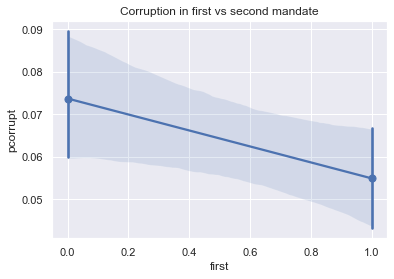

In [31]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# display the results

sns.set_theme()

ax = sns.regplot(x='first', y='pcorrupt', data=df, x_bins=2, x_estimator=np.mean)
ax.set_title('Corruption in first vs second mandate')

plt.show()
# We can clearly see higher corruption rates 


**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**


To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.


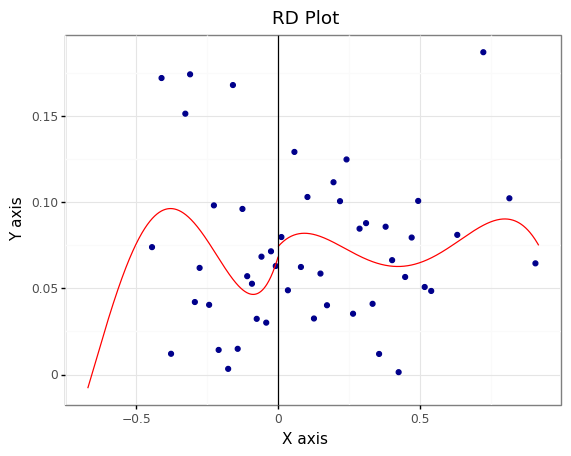


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     40         40
Average Bin Length             0.017      0.023
Median Bin Length              0.017      0.023
IMSE-optimal bins                5.0        3.0
Mimicking Variance bins         15.0       11.0

Relative to IMSE-optimal:
Implied scale                    8.0     13.333
WIMSE variance weight          0.002        0.0
WIMSE bias weight              0.998        1.0


In [55]:
# plot the RD plot using as running variable the variable winning_margin
# use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt
rdplot(corruption, margin, c=0, p=4, nbins=40)


In [101]:
# run the RD regression using the same dependent and explanatory variable as before
# include 4th degree polynomial and the covariates that you included above
covs = np.array(df.dropna(subset=['winning_margin'])['party']).astype(int)
print(rdrobust(corruption, margin, c=0, p=4, covs=covs))

# I'm sorry but I lost it
# I don't understand what we're doing here anymore


Call: rdrobust
Number of Observations:                   328
Polynomial Order Est. (p):                  4
Polynomial Order Bias (q):                  5
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Unique Obs.            126        201
Number of Effective Obs.          94        124
Bandwidth Estimation           0.205      0.205
Bandwidth Bias                 0.274      0.274
rho (h/b)                      0.748      0.748

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.027    0.042    0.644   5.198e-01    [-0.055, 0.109]
Robust                 -        -    0.827   4.080e-01    [-0.049, 0.119]



**Interpret the coefficient**


## Difference-in-Differences


In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis.


In [ ]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta',
                          iterator=True).variable_labels()
df_labels


In [ ]:
df.head()


The main outcome of interest is _totrob_, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (_inst1p_). The main regression is the following:

<center>$totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i$</center>


In [ ]:
# Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols1 = ...


**Why this estimate CANNOT be interpreted as causal?**


In [ ]:
# Plot the time series of car thefts separately for blocks with and without a jewish institutions
# Add a vertical line indicating the terrorist attack
import seaborn as sns
import matplotlib.pyplot as plt


**Does the parallel trend assumption hold?**


In [ ]:
# Run the regression above including month and block fixed effects
from linearmodels import PanelOLS
did = ...


In [ ]:
# show the results from both regressions


**Compare and interpret the results**
